# 1. Import packages

In [1]:
import sys
sys.path.append('..')
from modules import preprocess, benchmarking, graphics

Invoking __init__.py for modules


# 2. Load dataset

In [2]:
df = preprocess.load_csv_data('../dataset/Occupancy_Estimation.csv')

# 3. Data preprocessing
- Step 1: Transform features
  - Binary results for Room_Occupancy_Count
  - Drop Date and Time features
- Step 2: Clean data
  - Drop duplicated rows

In [3]:
# Step 1: Recode Room_Occupancy_Count column
preprocess.recode_dataset_output(df)

# Step 2: Filter Date and Time columns
preprocess.remove_time_columns(df)

df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


# 4. Benchmarking

In [4]:
# Split dataset into features and output
X = preprocess.get_features(df)
y = preprocess.get_output(df)

# Split dataset into training and test
X_train, X_test, y_train, y_test = preprocess.split_dataset(X, y)

## Create benchmarking Dataframe:
- Create benchmarking's df structure.
- Track models training with CodeCarbon and Eco2AI.
- Store in benchmarking's df tracking results.
- Store in benchmarking's df evaluation metrics.

In [5]:
df_benchmarking = benchmarking.create_benchmarking(X_train, y_train, X_test, y_test)

[codecarbon INFO @ 18:56:09] [setup] RAM Tracking...
[codecarbon INFO @ 18:56:09] [setup] GPU Tracking...
[codecarbon INFO @ 18:56:09] No GPU found.
[codecarbon INFO @ 18:56:09] [setup] CPU Tracking...
[codecarbon WARNING @ 18:56:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:56:11] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:56:11] >>> Tracker's metadata:
[codecarbon INFO @ 18:56:11]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:56:11]   Python version: 3.10.8
[codecarbon INFO @ 18:56:11]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:56:11]   CPU count: 4
[codecarbon INFO @ 18:56:11]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:56:11]   GPU count: None
[codecarbon INFO @ 18:56:11]   GPU model: None


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[codecarbon INFO @ 18:56:29] Energy consumed for RAM : 0.000000 kWh. RAM Power : 0.08478927612304688 W
[codecarbon INFO @ 18:56:30] Energy consumed for all CPUs : 0.000142 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:56:30] 0.000142 kWh of electricity used since the begining.
[codecarbon INFO @ 18:56:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08504104614257812 W
[codecarbon INFO @ 18:56:45] Energy consumed for all CPUs : 0.000277 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:56:45] 0.000278 kWh of electricity used since the begining.
[codecarbon INFO @ 18:56:46] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08522844314575195 W
[codecarbon INFO @ 18:56:46] Energy consumed for all CPUs : 0.000292 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:56:46] 0.000293 kWh of electricity used since the begining.
[codecarbon INFO @ 18:56:47] [setup] RAM Tracking...
[codecarbon INFO @ 18:56:47] [setup] GPU Tracking...
[codecarbon INFO @ 18:56:47] No GPU found.
[c

Best estimator LR:  Pipeline(steps=[('scaler', RobustScaler()),
                ('estimator',
                 LogisticRegression(C=78.47599703514607, max_iter=500,
                                    penalty='l1', solver='liblinear'))])
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


[codecarbon INFO @ 18:56:48] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:56:48] >>> Tracker's metadata:
[codecarbon INFO @ 18:56:48]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:56:48]   Python version: 3.10.8
[codecarbon INFO @ 18:56:48]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:56:48]   CPU count: 4
[codecarbon INFO @ 18:56:48]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:56:48]   GPU count: None
[codecarbon INFO @ 18:56:48]   GPU model: None


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[codecarbon INFO @ 18:57:07] Energy consumed for RAM : 0.000000 kWh. RAM Power : 0.085968017578125 W
[codecarbon INFO @ 18:57:07] Energy consumed for all CPUs : 0.000136 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:57:07] 0.000137 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:22] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08639860153198242 W
[codecarbon INFO @ 18:57:22] Energy consumed for all CPUs : 0.000272 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:57:22] 0.000273 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:40] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08645296096801758 W
[codecarbon INFO @ 18:57:40] Energy consumed for all CPUs : 0.000435 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:57:40] 0.000436 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.0864715576171875 W
[codecarbon INFO @ 18:57:44] Energy consumed for al

Best estimator RF:  RandomForestClassifier(bootstrap=False, max_depth=90, max_features=3,
                       min_samples_leaf=4, min_samples_split=12)
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


[codecarbon INFO @ 18:57:46] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:57:46] >>> Tracker's metadata:
[codecarbon INFO @ 18:57:46]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:57:46]   Python version: 3.10.8
[codecarbon INFO @ 18:57:46]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:57:46]   CPU count: 4
[codecarbon INFO @ 18:57:46]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:57:46]   GPU count: None
[codecarbon INFO @ 18:57:46]   GPU model: None


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[codecarbon INFO @ 18:58:04] Energy consumed for RAM : 0.000000 kWh. RAM Power : 0.08671331405639648 W
[codecarbon INFO @ 18:58:04] Energy consumed for all CPUs : 0.000136 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:58:04] 0.000136 kWh of electricity used since the begining.
[codecarbon INFO @ 18:58:19] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08662605285644531 W
[codecarbon INFO @ 18:58:19] Energy consumed for all CPUs : 0.000271 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:58:19] 0.000271 kWh of electricity used since the begining.
[codecarbon INFO @ 18:58:34] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08663463592529297 W
[codecarbon INFO @ 18:58:34] Energy consumed for all CPUs : 0.000406 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:58:34] 0.000407 kWh of electricity used since the begining.
[codecarbon INFO @ 18:58:49] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.09428787231445312 W
[codecarbon INFO @ 18:58:49] Energy consumed for

Best estimator SVM:  SVC(C=1, gamma=0.001)
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


[codecarbon INFO @ 18:59:05] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:59:05] >>> Tracker's metadata:
[codecarbon INFO @ 18:59:05]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:59:05]   Python version: 3.10.8
[codecarbon INFO @ 18:59:05]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:59:05]   CPU count: 4
[codecarbon INFO @ 18:59:05]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:59:05]   GPU count: None
[codecarbon INFO @ 18:59:05]   GPU model: None


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[codecarbon INFO @ 18:59:23] Energy consumed for RAM : 0.000000 kWh. RAM Power : 0.087432861328125 W
[codecarbon INFO @ 18:59:23] Energy consumed for all CPUs : 0.000136 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:59:23] 0.000136 kWh of electricity used since the begining.
[codecarbon INFO @ 18:59:38] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08745431900024414 W
[codecarbon INFO @ 18:59:38] Energy consumed for all CPUs : 0.000275 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:59:38] 0.000276 kWh of electricity used since the begining.
[codecarbon INFO @ 18:59:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08746004104614258 W
[codecarbon INFO @ 18:59:53] Energy consumed for all CPUs : 0.000411 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:59:53] 0.000412 kWh of electricity used since the begining.
[codecarbon INFO @ 19:00:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 0.08774757385253906 W
[codecarbon INFO @ 19:00:08] Energy consumed for a

Best estimator MLP:  Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 MLPClassifier(activation='identity', alpha=0.01,
                               hidden_layer_sizes=(100, 100, 100),
                               learning_rate='invscaling', max_iter=650))])
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


In [6]:
df_benchmarking

,Algoritmos,CodeCarbon (kWh),Eco2AI (kWh),Precision,Recall,F Score
0,Logistic Regression,0.000293,0.000333,1,0.998299,0.999149
1,Random Forest,0.000472,0.000193,1,0.998299,0.999149
2,Support Vector Machines,0.000666,0.000265,1,0.998299,0.999149
3,Multilayer Perceptron,0.002601,0.003600,1,0.998299,0.999149


## Save benchmarking's DataFrame in csv file

In [7]:
preprocess.save_in_csv_file(df_benchmarking, 'benchmarking.csv')

## Graphics

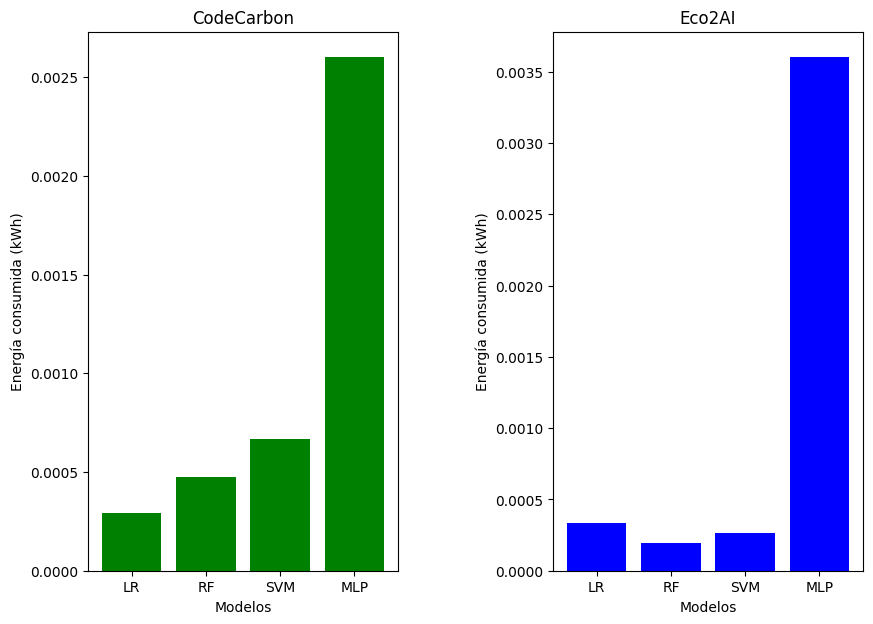

In [8]:
graphics.plot_models_energy_consumed(df_benchmarking)

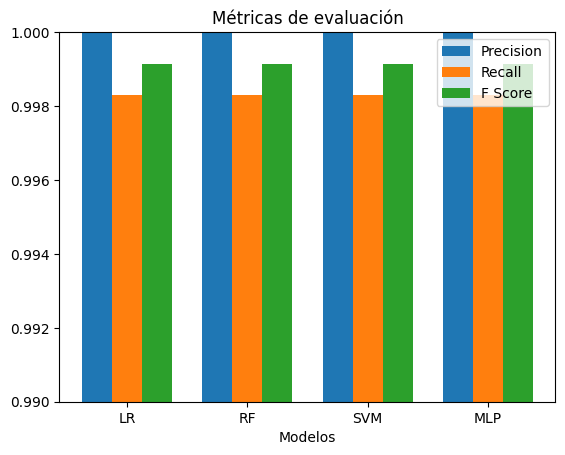

In [9]:
graphics.plot_models_evaluation_metrics(df_benchmarking)